In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from __future__ import print_function

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

# Autocorrelation analysis & convergence

In this tutorial, we will discuss a method for convincing yourself that your chains are sufficiently converged.
This can be a difficult subject to discuss because it isn't formally possible to guarantee convergence for any but the simplest models, and therefore any argument that you make will be circular and heuristic.
However, some discussion of autocorrelation analysis is (or should be!) a necessary part of any publication using MCMC.

With emcee, we follow [Goodman & Weare (2010)](http://msp.berkeley.edu/camcos/2010/5-1/p04.xhtml) and recommend using the *integrated autocorrelation time* to quantify the effects of sampling error on your results.
The basic idea is that the samples in your chain are not independent and you must estimate the effective number of independent samples.
There are other convergence diagnostics like the [Gelman–Rubin statistic](http://digitalassets.lib.berkeley.edu/sdtr/ucb/text/305.pdf) (*Note: you should not compute the G–R statistic using multiple chains in the same emcee ensemble because the chains are not independent!*) but, since the integrated autocorrelation time directly quantifies the Monte Carlo error (and hence the efficiency of the sampler) on any integrals computed using the MCMC results, it is the natural quantity of interest when judging the robustness of an MCMC analysis.

## Monte Carlo error

The goal of every MCMC analysis is to evaluate integrals of the form

$$
\mathrm{E}_{p(\theta)}[f(\theta)] = \int f(\theta)\,p(\theta)\,\mathrm{d}\theta \quad.
$$

If you had some way of generating $N$ samples $\theta^{(n)}$ from the probability density $p(\theta)$, then you could approximate this integral as

$$
\mathrm{E}_{p(\theta)}[f(\theta)] \approx \frac{1}{N} \sum_{n=1}^N f(\theta^{(n)})
$$

where the sum is over the samples from $p(\theta)$.
If these samples are independent, then the sampling variance on this estimator is

$$
\sigma^2 = \frac{1}{N}\,\mathrm{Var}_{p(\theta)}[f(\theta)]
$$

and the error decreses as $1/\sqrt{N}$ as you generate more samples.
In the case of MCMC, the samples are not independent and the error is actually given by

$$
\sigma^2 = \frac{\tau_f}{N}\,\mathrm{Var}_{p(\theta)}[f(\theta)]
$$

where $\tau_f$ is the *integrated autocorrelation time* for the chain $f(\theta^{(n)})$.
In other words, $N/\tau_f$ is the effective number of samples and $\tau_f$ is the number of steps that are needed before the chain "forgets" where it started.
This means that, if you can estimate $\tau_f$, then you can estimate the number of samples that you need to generate to reduce the relative error on your target integral to (say) a few percent.

**Note:** It is important to remember that $\tau_f$ depends on the specific function $f(\theta)$.
This means that there isn't just *one* integrated autocorrelation time for a given Markov chain.
Instead, you must compute a different $\tau_f$ for any integral you estimate using the samples.

## Computing autocorrelation times

There is a great discussion of methods for autocorrelation estimation in [a set of lecture notes by Alan Sokal](https://pdfs.semanticscholar.org/0bfe/9e3db30605fe2d4d26e1a288a5e2997e7225.pdf) and the interested reader should take a look at that for a more formal discussion, but I'll include a summary of some of the relevant points here.
The integrated autocorrelation time is defined as

$$
\tau_f = \sum_{\tau=-\infty}^\infty \rho_f(\tau)
$$

where $\rho_f(\tau)$ is the normalized autocorrelation function of the stochastic process that generated the chain for $f$.
You can estimate $\rho_f(\tau)$ using a finite chain $\{f_n\}_{n=1}^N$ as

$$
\hat{\rho}_f(\tau) = \hat{c}_f(\tau) / \hat{c}_f(0)
$$

where

$$
\hat{c}_f(\tau) = \frac{1}{N - \tau} \sum_{n=1}^{N-\tau} (f_n - \mu_f)\,(f_{n+\tau}-\mu_f)
$$

and

$$
\mu_f = \frac{1}{N}\sum_{n=1}^N f_n \quad.
$$

(Note: In practice, it is actually more computationally efficient to compute $\hat{c}_f(\tau)$ using a fast Fourier transform than summing it directly.)

Now, you might expect that you can estimate $\tau_f$ using this estimator for $\rho_f(\tau)$ as

$$
\hat{\tau}_f \stackrel{?}{=} \sum_{\tau=-N}^{N} \hat{\rho}_f(\tau) = 1 + 2\,\sum_{\tau=1}^N \hat{\rho}_f(\tau)
$$

but this isn't actually a very good idea.
At longer lags, $\hat{\rho}_f(\tau)$ starts to contain more noise than signal and summing all the way out to $N$ will result in a very noisy estimate of $\tau_f$.
Instead, we want to estimate $\tau_f$ as

$$
\hat{\tau}_f (M) = 1 + 2\,\sum_{\tau=1}^M \hat{\rho}_f(\tau)
$$

for some $M \ll N$.
As discussed by Sokal in the notes linked above, the introduction of $M$ decreases the variance of the estimator at the cost of some added bias and he suggests choosing the smallest value of $M$ where $M \ge C\,\hat{\tau}_f (M)$ for a constant $C \sim 5$.
Sokal says that he finds this procedure to work well for chains longer than $1000\,\tau_f$, but the situation is a bit better with emcee because we can use the parallel chains to reduce the variance and we've found that chains longer than about $30\,\tau$ are often sufficient.

## A toy problem

To demonstrate this method, we'll start by generating a set of "chains" from a process with known autocorrelation structure.
To generate a large enough dataset, we'll use [celerite](http://celerite.readthedocs.io):

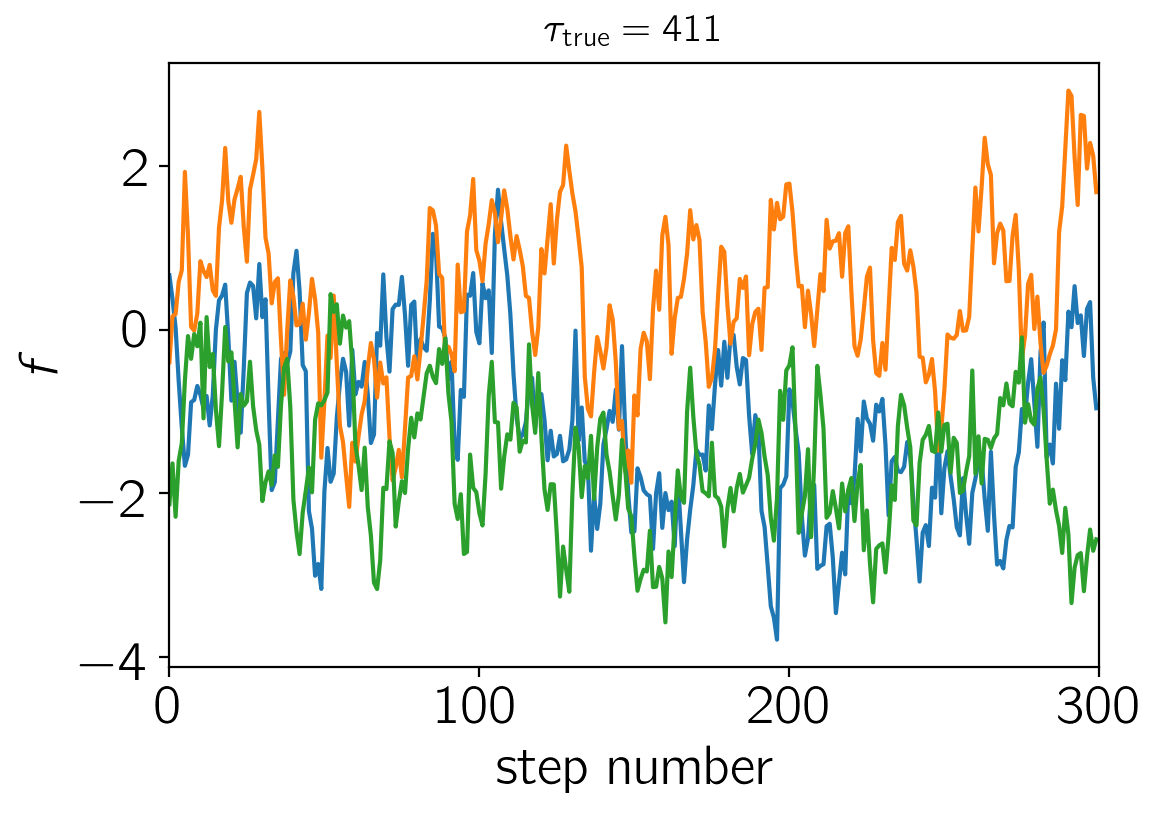

In [291]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123456)

# Build the celerite model:
import celerite
from celerite import terms
kernel = terms.RealTerm(log_a=0.0, log_c=-6.0)
kernel += terms.RealTerm(log_a=0.0, log_c=-2.0)

# The true autocorrelation time can be calculated analytically:
true_tau = sum(2*np.exp(t.log_a-t.log_c) for t in kernel.terms)
true_tau /= sum(np.exp(t.log_a) for t in kernel.terms)
true_tau

# Simulate a set of chains:
gp = celerite.GP(kernel)
t = np.arange(1000000)
gp.compute(t)
y = gp.sample(size=10)

# Let's plot a little segment with a few samples:
plt.plot(y[:3, :300].T)
plt.xlim(0, 300)
plt.xlabel("step number")
plt.ylabel("$f$")
plt.title("$\\tau_\mathrm{{true}} = {0:.0f}$".format(true_tau), fontsize=14);

Now we'll estimate the empirical autocorrelation function for each of these parallel chains and compare this to the true function.

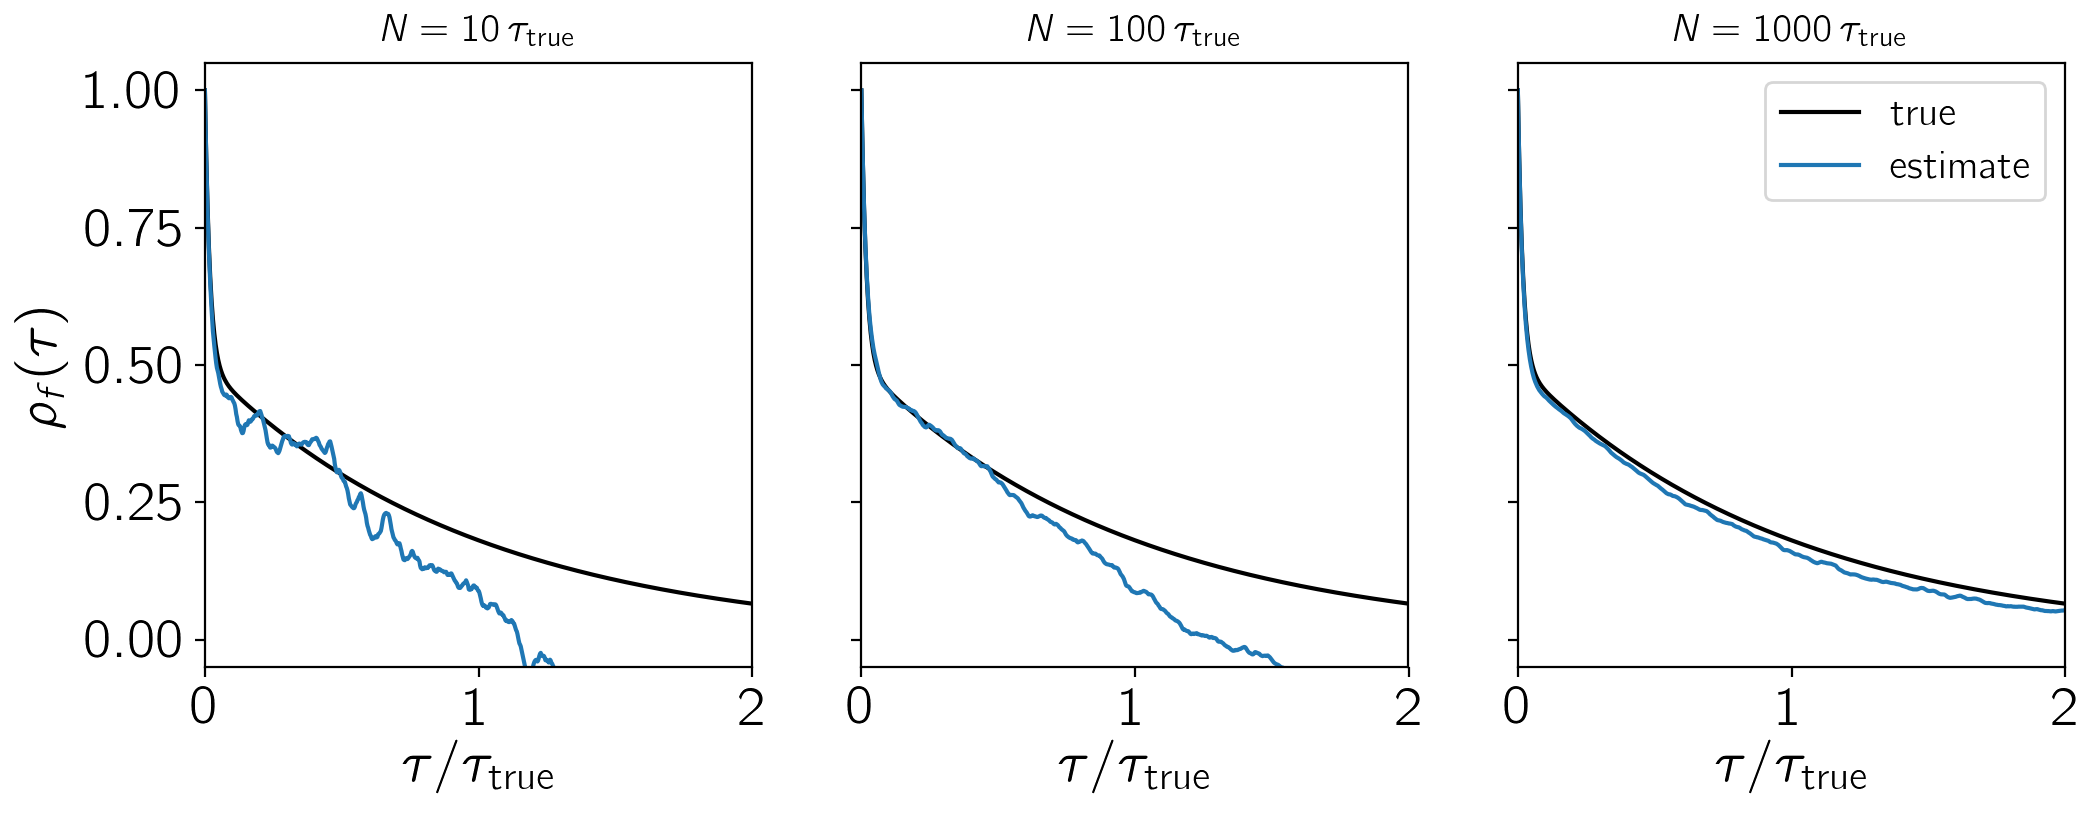

In [292]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2*n)
    acf = np.fft.ifft(f * np.conjugate(f))[:len(x)].real
    acf /= 4*n
    
    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf

# Make plots of ACF estimate for a few different chain lengths
window = int(2*true_tau)
tau = np.arange(window+1)
f0 = kernel.get_value(tau) / kernel.get_value(0.0)

# Loop over chain lengths:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
for n, ax in zip([10, 100, 1000], axes):
    nn = int(true_tau * n)
    ax.plot(tau / true_tau, f0, "k", label="true")
    ax.plot(tau / true_tau, autocorr_func_1d(y[0, :nn])[:window+1], label="estimate")
    ax.set_title(r"$N = {0}\,\tau_\mathrm{{true}}$".format(n), fontsize=14)
    ax.set_xlabel(r"$\tau / \tau_\mathrm{true}$")

axes[0].set_ylabel(r"$\rho_f(\tau)$")
axes[-1].set_xlim(0, window / true_tau)
axes[-1].set_ylim(-0.05, 1.05)
axes[-1].legend(fontsize=14);

This figure shows how the empirical estimate of the normalized autocorrelation function changes as more samples are generated.
In each panel, the true autocorrelation function is shown as a black curve and the empricial estimator is shown as a blue line.

Instead of estimating the autocorrelation function using a single chain, we can assume that each chain is sampled from the same stochastic process and average the estimate over ensemble members to reduce the variance.
It turns out that we'll actually want to average later in the process below, but it can be useful to show the mean autocorrelation function for visualization purposes.

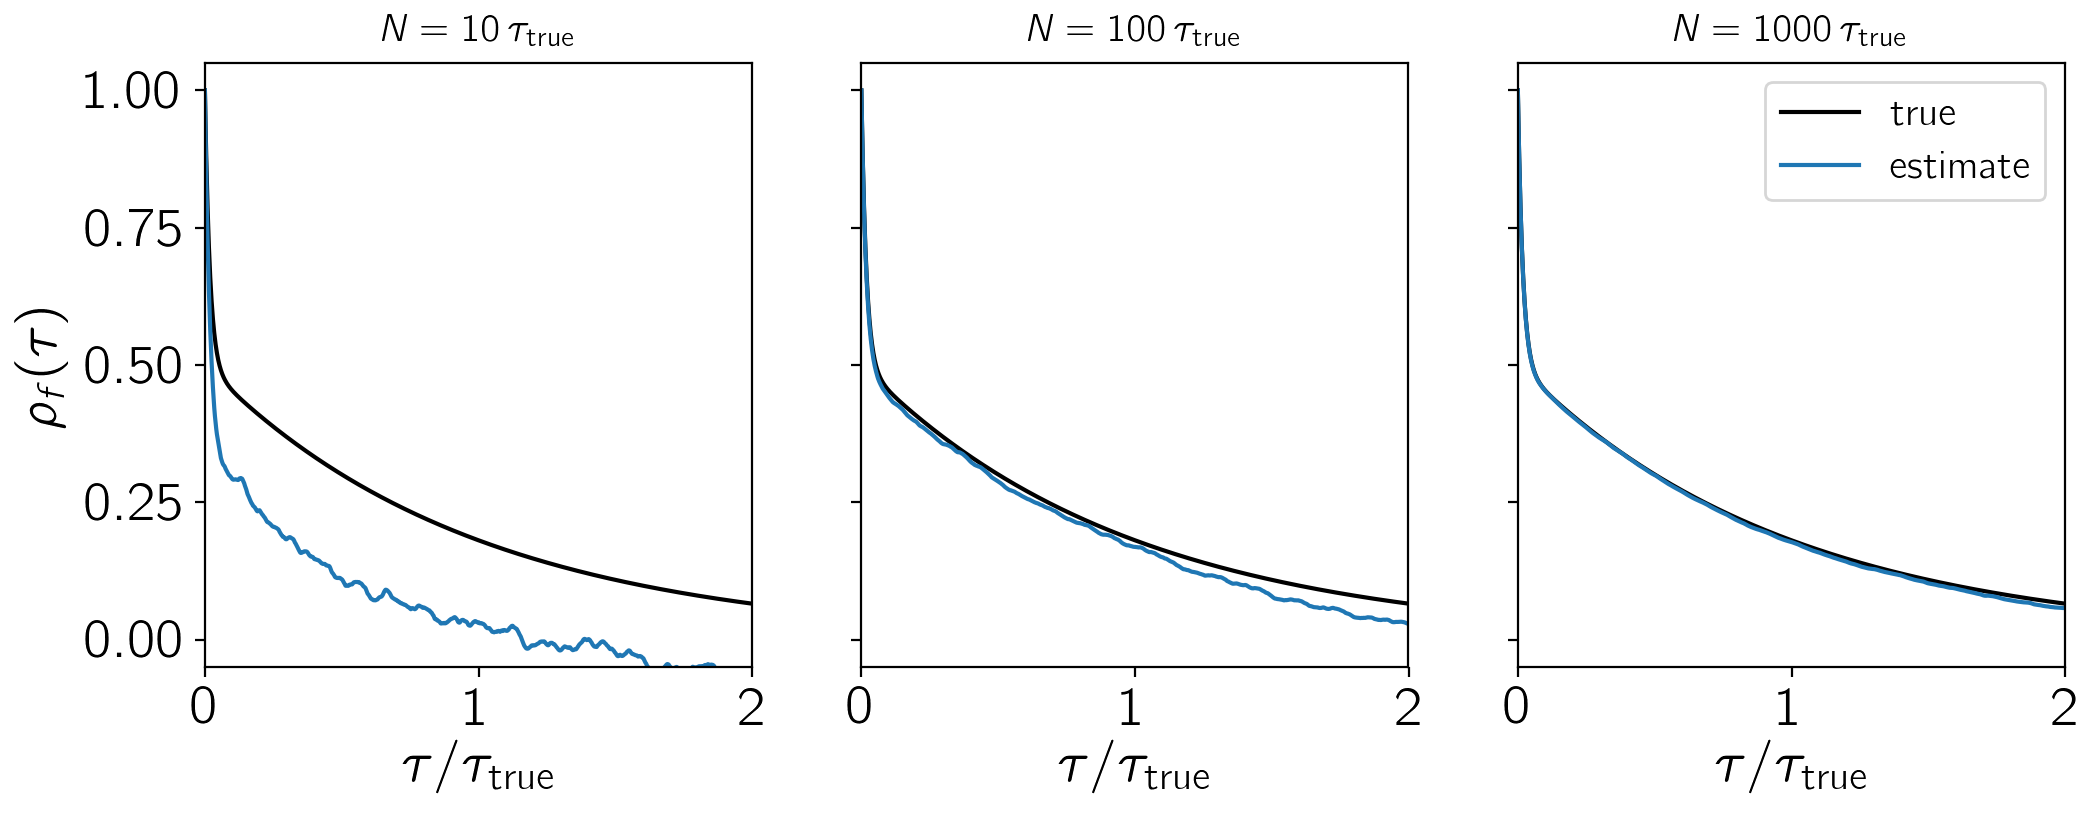

In [293]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
for n, ax in zip([10, 100, 1000], axes):
    nn = int(true_tau * n)
    ax.plot(tau / true_tau, f0, "k", label="true")
    f = np.mean([autocorr_func_1d(y[i, :nn], norm=False)[:window+1]
                 for i in range(len(y))], axis=0)
    f /= f[0]
    ax.plot(tau / true_tau, f, label="estimate")
    ax.set_title(r"$N = {0}\,\tau_\mathrm{{true}}$".format(n), fontsize=14)
    ax.set_xlabel(r"$\tau / \tau_\mathrm{true}$")

axes[0].set_ylabel(r"$\rho_f(\tau)$")
axes[-1].set_xlim(0, window / true_tau)
axes[-1].set_ylim(-0.05, 1.05)
axes[-1].legend(fontsize=14);

Now let's try to estimate the 

In [294]:
def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1

# Following the suggestion from Goodman & Weare (2010)
def autocorr_gw2010(y, c=5.0):
    f = autocorr_func_1d(np.mean(y, axis=0))
    taus = 2.0*np.cumsum(f)-1.0
    window = auto_window(taus, c)
    return taus[window]

def autocorr_new(y, c=5.0):
    taus = np.zeros(y.shape[1])
    for yy in y:
        f = autocorr_func_1d(yy)
        taus += 2.0*np.cumsum(f)-1.0
    taus /= len(y)
    window = auto_window(taus, c)
    return taus[window]

In [298]:
N = np.exp(np.linspace(np.log(100), np.log(y.shape[1]), 10)).astype(int)
gw2010 = np.empty(len(N))
new = np.empty(len(N))

for i, n in enumerate(N):
    gw2010[i] = autocorr_gw2010(y[:, :n])
    new[i] = autocorr_new(y[:, :n])
    print(n, true_tau, gw2010[i], new[i])

100 410.817849592 4.43911877091 5.84105400206
278 410.817849592 9.32529524573 14.8307721032
774 410.817849592 54.9767535536 42.315447127
2154 410.817849592 67.0331856516 70.76122138
5994 410.817849592 141.516519589 132.671721629
16681 410.817849592 113.730692334 252.364593832
46415 410.817849592 189.569827435 358.234652795
129154 410.817849592 220.327109905 399.983955206
359381 410.817849592 414.76215285 387.055182518
999999 410.817849592 402.465595614 393.810118699


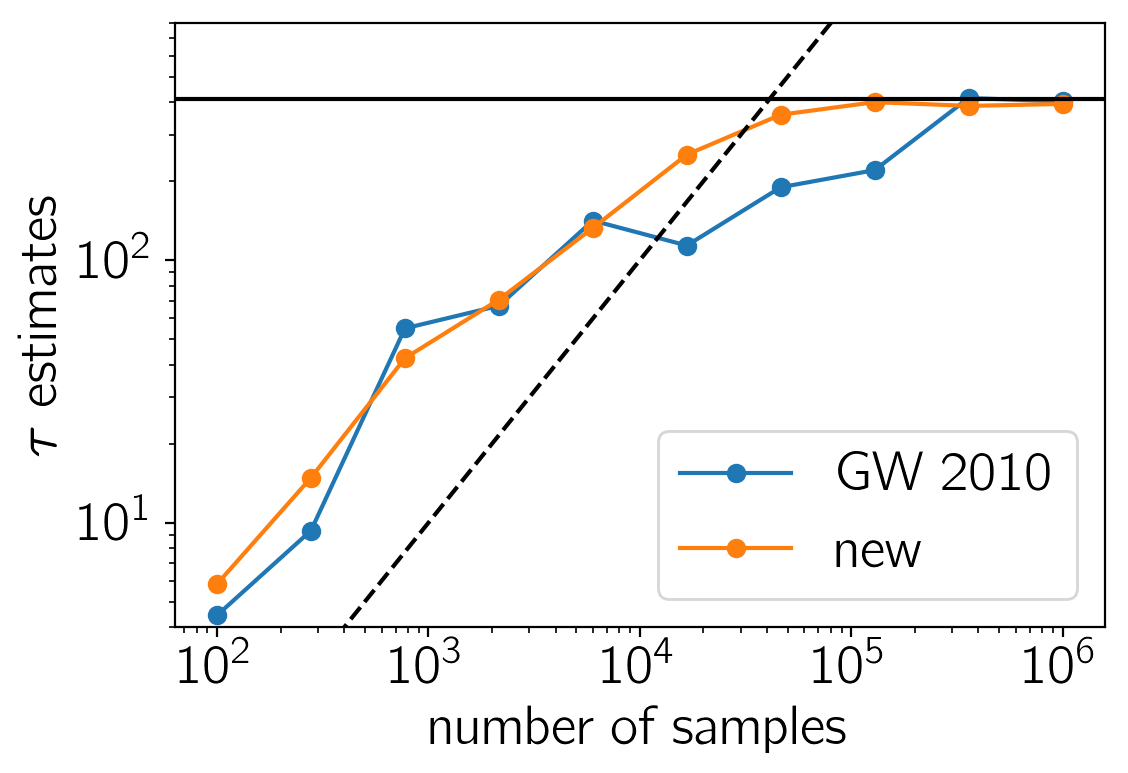

In [300]:
plt.loglog(N, gw2010, "o-", label="G&W 2010")
plt.loglog(N, new, "o-", label="new")
plt.plot(N, N / 100.0, "--k")
plt.ylim(4, 800)
plt.axhline(true_tau, color="k")
plt.xlabel("number of samples")
plt.ylabel(r"$\tau$ estimates")
plt.legend();

In [435]:
import emcee
emcee.autocorr.integrated_time(np.mean(y, axis=0), c=5)

392.38006572186202

In [436]:
true_tau

410.81784959166578

In [446]:
import logging

def next_pow_two(n):
    """Returns the next power of two greater than or equal to `n`."""
    i = 1
    while i < n:
        i = i << 1
    return i

def autocorr_func_1d(x, norm=True):
    """Estimate the autocorrelation function of a time series using the FFT.
    Args:
        x: The time series. If multidimensional, set the time axis using the
            ``axis`` keyword argument and the function will be computed for
            every other axis.
        axis (Optional[int]): The time axis of ``x``. Assumed to be the first
            axis if not specified.
        fast (Optional[bool]): (depricated) ignored; the algorithm
            always pads to the nearest power of two.
    Returns:
        array: The autocorrelation function of the time series.
    """
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2*n)
    acf = np.fft.ifft(f * np.conjugate(f))[:n].real
    
    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf
    
def integrated_time(x, tol=30, c=5.0, throw=False, warn=True):
    # Compute the autocorrelation function estimator
    
    f = np.mean(2.0*np.cumsum([autocorr_func_1d(x0, norm=True) for x0 in x], axis=1)-1.0, axis=0)
    window = np.argmax(f)
    tau = f[window]
#     window = np.argmin(np.arange(f.shape[1])[None, :] < c * f, axis=1)
#     tau = np.mean(f[range(len(f)), window])

    success = True
    if tol > 0 and tau*tol >= x.shape[1]:
        success = False
        msg = ("The dataset is shorter than {0} times the current estimate "
               "of the autocorrelation time. Use this estimate with caution.")
        msg = msg.format(tol)
        if throw:
            raise AutocorrError(msg)
        if warn:
            logging.warning(msg)
    return AutocorrResults(tau, window, success)

class AutocorrError(Exception):
    """Raised if the chain is too short to estimate an autocorrelation time.
    """
    pass

from collections import namedtuple

AutocorrResults = namedtuple("AutocorrResults", ["tau", "window", "success"])        

In [447]:
N = np.exp(np.linspace(np.log(100), np.log(y.shape[1]), 10)).astype(int)
orig = np.empty(len(N))
new = np.empty(len(N))
flags = np.empty(len(N), dtype=bool)

for i, n in enumerate(N):
    orig[i] = emcee.autocorr.integrated_time(np.mean(y[:, :n], axis=0), c=3, quiet=True)
    result = integrated_time(y[:, :n], warn=True)
    new[i] = result.tau
    flags[i] = result.success

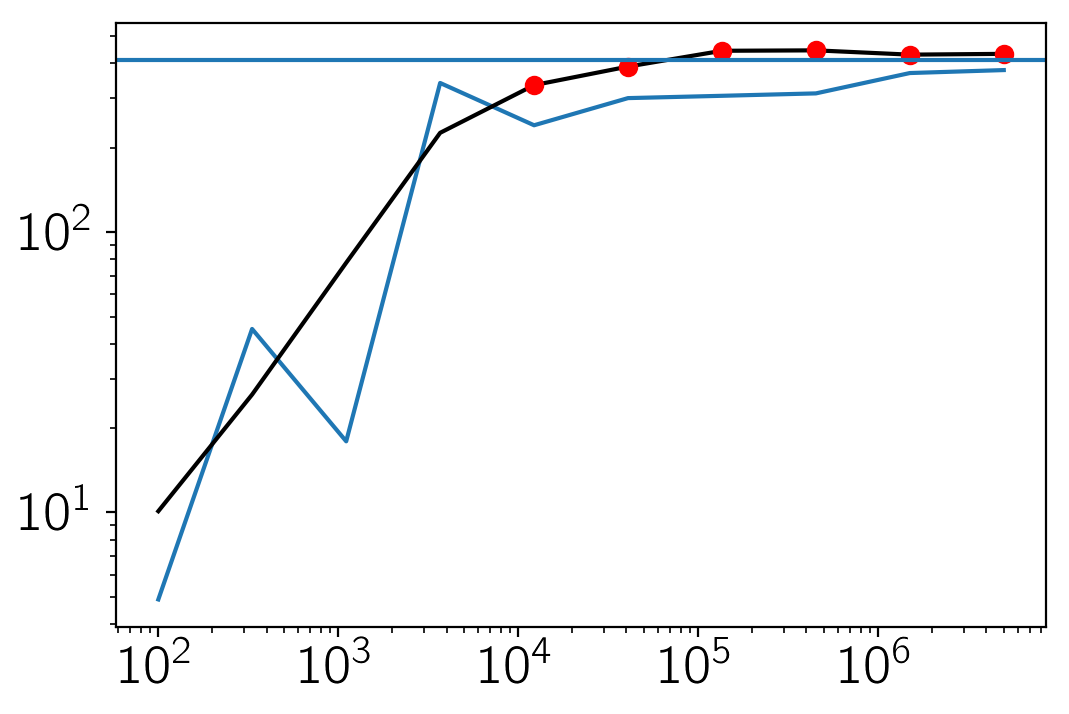

In [448]:
plt.plot(N, orig)
plt.loglog(N, new, "k")
plt.plot(N[flags], new[flags], "or")
plt.axhline(true_tau)

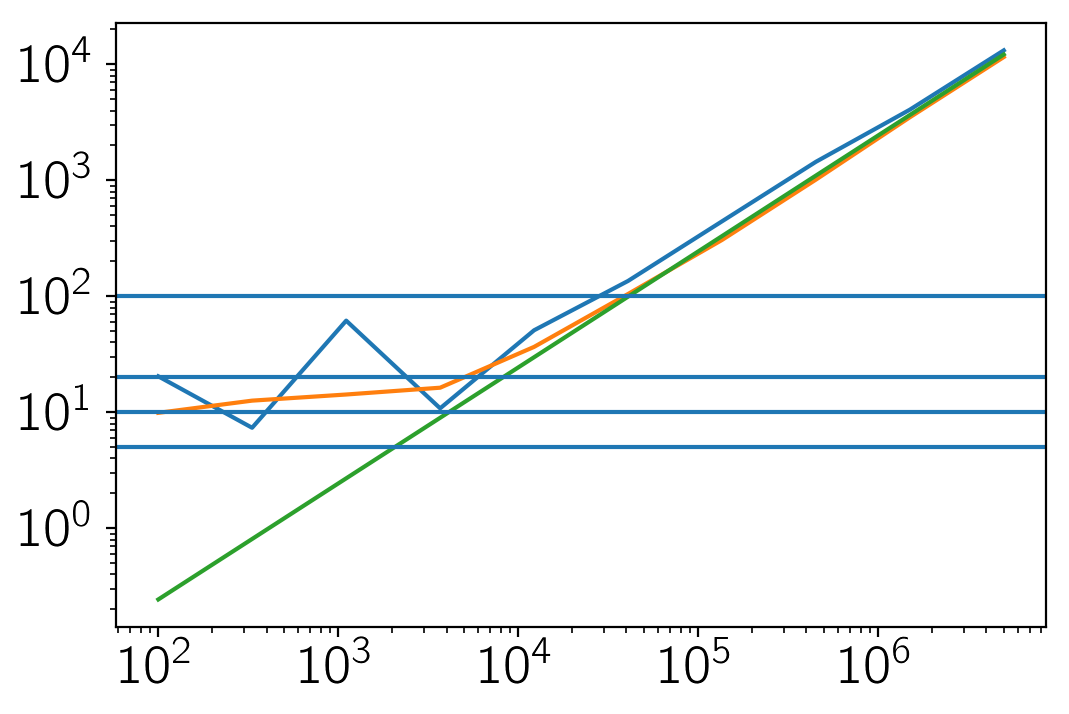

In [450]:
plt.loglog(N, N/orig)
plt.loglog(N, N/new)
plt.loglog(N, N / true_tau)
plt.axhline(5)
plt.axhline(10)
plt.axhline(20)
plt.axhline(100)

In [15]:
def log_prob(p):
    return np.logaddexp(-0.5*np.sum(p**2), -0.5*np.sum((p-4.0)**2))

sampler = emcee.EnsembleSampler(32, 3, log_prob)
sampler.run_mcmc(np.concatenate((np.random.randn(16, 3),
                                 4.0+np.random.randn(16, 3)), axis=0),
                 500000, progress=True);

100%|██████████| 500000/500000 [05:25<00:00, 1534.53it/s]


In [266]:
y2 = sampler.chain[:, :, 0].T

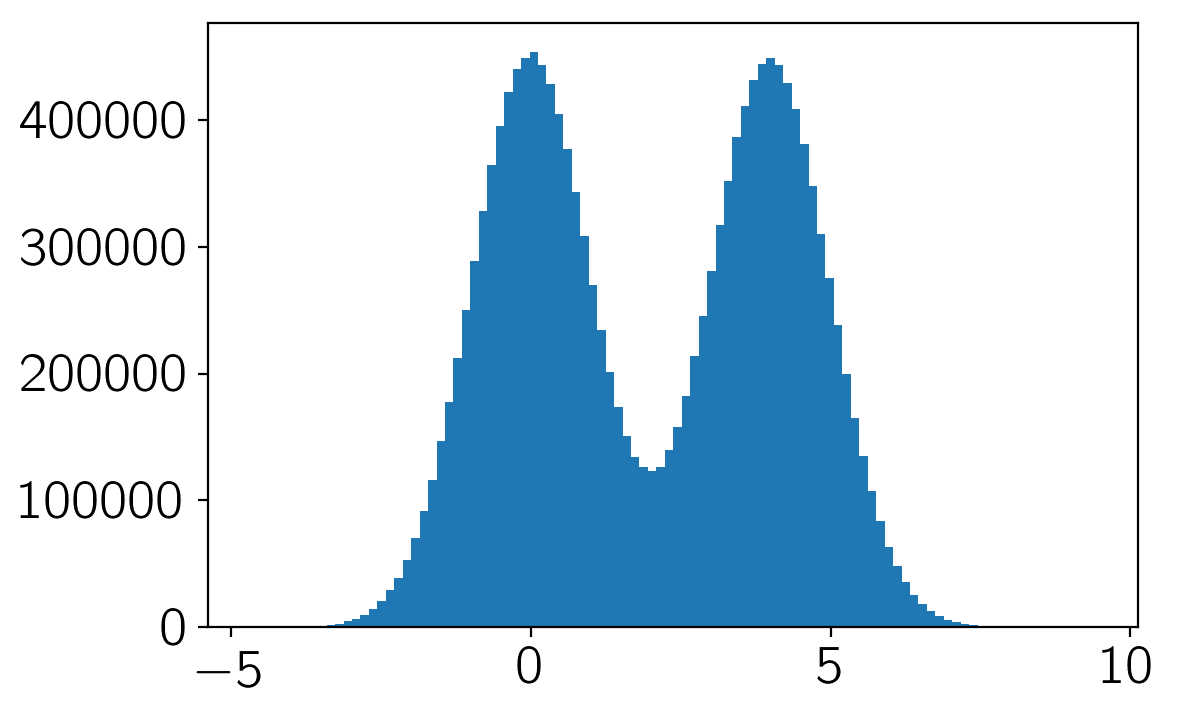

In [267]:
plt.hist(y2.flatten(), 100);

In [426]:
from scipy.optimize import minimize

import autograd.numpy as np

class CustomTerm(terms.Term):
    parameter_names = ("a", "tau")
    
    def get_real_coefficients(self, params):
        a, tau = params
        return a, 1.0/tau

def ml_acorr(y, init, thin=1):
    z = y[:, ::thin]
    print(init)
    print(-np.log(init/thin))
    N = z.shape[1]
    kernel = CustomTerm(np.var(z), init/thin,
                              bounds=[(0.0, np.exp(5.0)), (1.0, N)])
    kernel += CustomTerm(np.var(z), 2.0*init/thin,
                              bounds=[(0.0, np.exp(5.0)), (1.0, N)])
    kernel += terms.JitterTerm(np.log(np.mean(np.abs(np.diff(z)))))
    gp = celerite.GP(kernel, mean=np.mean(z))
    gp.compute(np.arange(z.shape[1]))

    def nll(p):
        gp.set_parameter_vector(p)
        v, g = zip(*(
            gp.grad_log_likelihood(z0, quiet=True)
            for z0 in z
        ))
        return -np.sum(v), -np.sum(g, axis=0)

    p0 = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()
    
    soln = minimize(nll, p0, jac=True, bounds=bounds)
    print(soln)
    
    a, c = kernel.coefficients[:2]

    return thin * 2*np.sum(a / c) / np.sum(a)

In [429]:
N = np.exp(np.linspace(np.log(50), np.log(y2.shape[1]), 10)).astype(int)
orig = np.empty(len(N))
new = np.empty(len(N))
ml = np.empty(len(N))
flags = np.empty(len(N), dtype=bool)

for i, n in enumerate(N):
    orig[i] = emcee.autocorr.integrated_time(np.mean(y2[:, :n], axis=0), c=3, quiet=True)
    soln = integrated_time(y2[:, :n], warn=True, tol=20)
    new[i] = soln.tau
    flags[i] = soln.success
    thin = max(1, int(0.05*soln.tau))
    print("thin: ", thin)
    ml[i] = ml_acorr(y2[:, :n], soln.tau, thin=thin)
    print(orig[i], new[i], ml[i])

thin:  1
3.59266936512
-1.27889548194


      fun: -240.77814624384908
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.12325598, -0.00176732,  0.0663935 , -0.05098648, -0.        ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 35
      nit: 23
   status: 0
  success: True
        x: array([  0.50479429,  42.10283954,   4.35483977,  49.        , -21.6648419 ])
nan 3.59266936512 96.5671154873
thin:  1
10.4390398393
-2.34555260881


      fun: -1404.7961152441437
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.19107676e-03,   8.09994418e-05,  -3.40090240e-05,
        -3.59519030e-02,  -0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 76
      nit: 48
   status: 0
  success: True
        x: array([   0.29772076,    4.4256133 ,    3.84469687,  139.        ,
        -74.00633278])
9.72255646545 10.4390398393 258.655939528
thin:  1
28.6250959149
-3.35428381261


      fun: -3926.4722481915833
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -5.61541903e-03,   2.47567319e-04,  -2.63180086e-04,
         5.59751475e-06,  -1.60601689e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 78
      nit: 55
   status: 0
  success: True
        x: array([   0.329241  ,    5.06012155,    4.7129402 ,  153.40095737,
         -2.66613146])
40.6406208077 28.6250959149 287.42939185
thin:  3
74.6029506266
-3.2135677704


      fun: 1281.1343633170848
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.21468977e-02,  -5.81801395e-03,  -1.10045694e-03,
         3.68042137e-05,   1.06228103e-02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 77
      nit: 59
   status: 0
  success: True
        x: array([  0.59695556,   3.8064594 ,   4.28982624,  98.19332069,  -1.48880218])
94.4723499792 74.6029506266 519.979718038
thin:  8
168.670903006
-3.04850795526
      fun: 5194.5421992576903
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.02441839, -0.01054458, -0.01719434,  0.00064962,  0.00632116])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 76
      nit: 60
   status: 0
  success: True
        x: array([  0.65333653,   2.57183028,   4.06383096,  39.25324362,  -0.95621105])
202.026728256 168.670903006 546.764786723
thin:  17
348.362338158
-3.02002979565
      fun: 10130.761770094305
 hess_inv: <5x5 Lbfgs

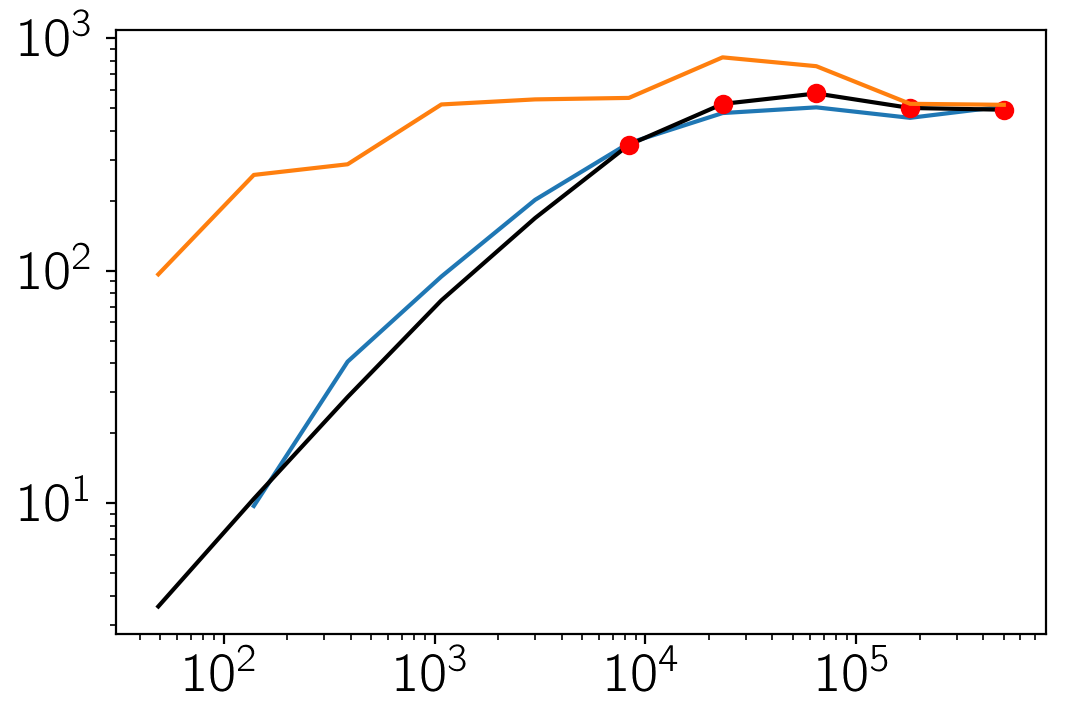

In [430]:
k = len(N)
plt.plot(N[:k], orig[:k])
plt.loglog(N[:k], new[:k], "k")
plt.plot(N[:k][flags[:k]], new[:k][flags[:k]], "or")
plt.loglog(N[:k], ml[:k])

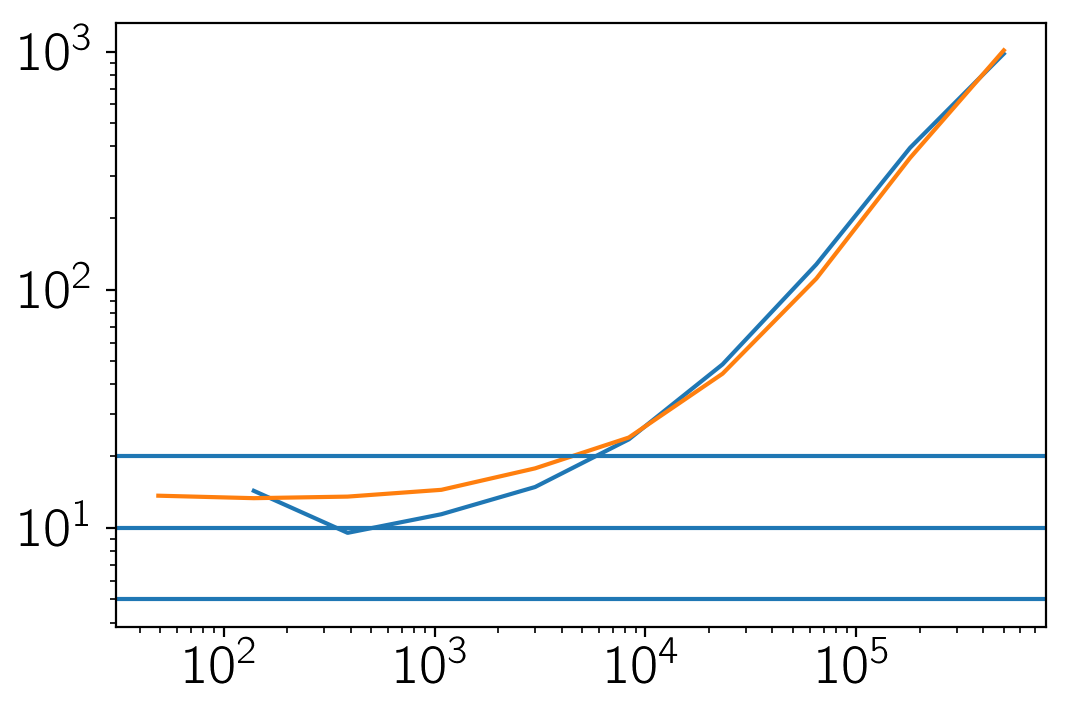

In [271]:
plt.loglog(N, N/orig)
plt.loglog(N, N/new)
plt.axhline(5)
plt.axhline(10)
plt.axhline(20)

In [382]:
thin = 5
z = y2[:, :5000:thin]

# kernel = terms.SHOTerm(
#     log_S0=np.log(np.var(z)),
#     log_omega0=-np.log(new[-1]),
#     log_Q=np.log(0.1),
#     bounds=dict(log_Q=(-5.0, -np.log(2.0)-1e-5))
# )
kernel = terms.RealTerm(np.log(np.var(z)), -np.log(new[-1]/thin))
kernel += terms.RealTerm(np.log(np.var(z)), -np.log(2.0*new[-1]/thin))
kernel += terms.JitterTerm(np.log(np.mean(np.abs(np.diff(z)))))
gp = celerite.GP(kernel, mean=np.mean(z))
gp.compute(np.arange(z.shape[1]))

In [383]:
z.shape

(32, 1000)

In [390]:
from scipy.optimize import minimize

def nll(p):
    gp.set_parameter_vector(p)
    v, g = zip(*(
        gp.grad_log_likelihood(z0, quiet=True)
        for z0 in z
    ))
    print(np.sum(g, axis=0))
    return -np.sum(v), -np.sum(g, axis=0)

p0 = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()
nll(p0)

[ 1020.92529517  1060.41569303   492.58279636   525.27267861 -2010.7371324 ]


(10266.483366183318,
 array([-1020.92529517, -1060.41569303,  -492.58279636,  -525.27267861,
         2010.7371324 ]))

In [391]:
soln = minimize(nll, p0, jac=True, bounds=bounds)
soln

[ 1020.92529517  1060.41569303   492.58279636   525.27267861 -2010.7371324 ]
[ 4037.66468391  4123.4920741   1309.90404275  1350.80194663  5845.11906368]
[ 1490.18262581  1537.5801795    658.316419     692.83898708  1814.2074983 ]
[ 1142.31351798  1202.28029694   436.33511747   473.16577313  1228.73632399]
[-1050.35303157  -915.56009186  -285.09233844  -241.3574282   -951.23839367]
[ 178.65505386  273.44921363   22.81468584   63.9243148    85.83615818]
[-22.02761102  80.50044614 -39.42583684   2.30921541 -74.42229599]
[-72.46849154  33.08524587 -54.08970556 -12.17817659 -78.59594857]
[-104.93181419    4.96664546  -63.03090517  -21.02787342  -37.94662478]
[-178.32943637  -51.18442658  -78.58693556  -36.90367274   91.4146633 ]
[-389.71596514 -216.84390064  -97.31509303  -60.40278663  149.86988061]
[-1253.079705   -1200.62384847    98.94618144    49.39095105  -411.81157165]
[-716.58186441 -505.65275133  -74.23836528  -57.87627781    0.98995389]
[-469.98185846 -581.8478316   168.45208013  

      fun: 8980.7420402948956
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.05109359,  0.03614582,  0.02143374,  0.02229336,  0.04225909])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 41
      nit: 28
   status: 0
  success: True
        x: array([-0.69106654, -0.81168085,  1.46916901, -3.95844773, -1.24181766])

In [392]:
p0

array([ 1.59602967, -4.59224517,  1.59602967, -5.28539235, -0.5252008 ])

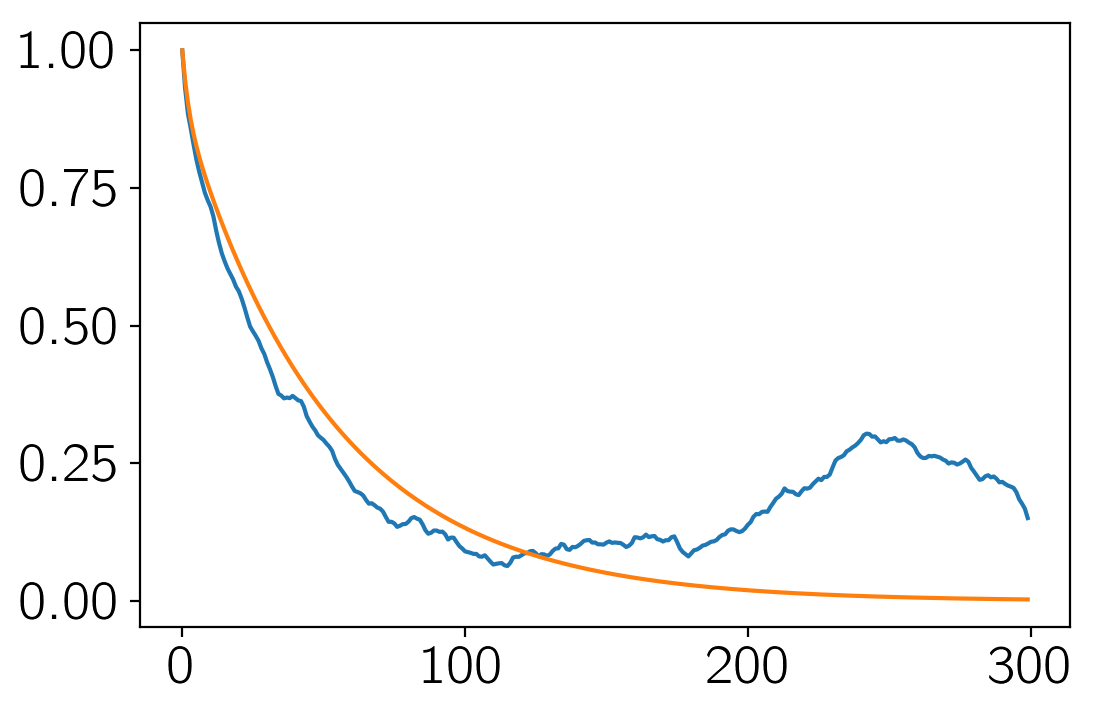

In [394]:
plt.plot(autocorr_func_1d(z[0])[:300])
tt = np.arange(300)
plt.plot(tt, kernel.get_value(tt) / kernel.get_value(0.0))

In [395]:
a, c = kernel.coefficients[:2]

2*np.sum(a / c) / np.sum(a)

94.388366785762088

In [396]:
new[-1] / thin

98.715814937822415

In [363]:
kernel.get_coeffs_jacobian()

array([[ 0.45283864,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.52864827,  0.        ],
       [ 0.        ,  4.33996475,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.03682348],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

In [364]:
a, c

(array([ 0.45283864,  4.33996475]), array([ 0.52864827,  0.03682348]))